In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import plotly as plot
import plotly.graph_objects as go

In [175]:
data = pd.read_csv("btcusdt_1h.csv")

In [176]:
data.head()

,datetime,open,high,low,close,volume
0,2018-01-01 05:30:00,13715.65,13715.65,13400.01,13529.01,443.356199
1,2018-01-01 06:30:00,13528.99,13595.89,13155.38,13203.06,383.697006
2,2018-01-01 07:30:00,13203.00,13418.43,13200.00,13330.18,429.064572
3,2018-01-01 08:30:00,13330.26,13611.27,13290.00,13410.03,420.087030
4,2018-01-01 09:30:00,13434.98,13623.29,13322.15,13601.01,340.807329


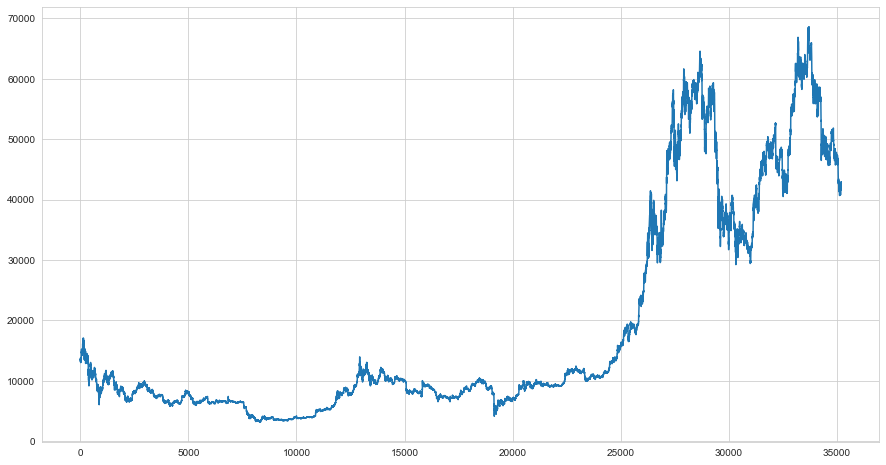

In [146]:
plt.figure(figsize = (15, 8))
plt.plot(data['close'])
plt.show()

In [147]:
len(data)

35208

In [177]:
lookback = 64

weights_1 = []
for i in range(1, lookback+1):
    weights_1.append(i)
weights_1 = np.array(weights_1)
sum_weights_1 = np.sum(weights_1)

weights_2 = []
for i in range(1, int(lookback/2)+1):
    weights_2.append(i)
weights_2 = np.array(weights_2)
sum_weights_2 = np.sum(weights_2)

weights_3 = []
for i in range(1, int(np.sqrt(lookback))+1):
    weights_3.append(i)
weights_3 = np.array(weights_3)
sum_weights_3 = np.sum(weights_3)

In [178]:
data['wma_1'] = (data['close']
            .rolling(window = int(lookback/2), center = False)
            .apply(lambda x : np.sum(weights_2 * x) / sum_weights_2, raw = False))

data['wma_1'] = 2 * data['wma_1']

data['wma_2'] = (data['close']
            .rolling(window = lookback, center = False)
            .apply(lambda x : np.sum(weights_1 * x) / sum_weights_1, raw = False))

data['wma_diff'] = data['wma_1'] - data['wma_2']

data['hma'] = (data['wma_diff']
            .rolling(window = int(np.sqrt(lookback)), center = False)
            .apply(lambda x : np.sum(weights_3 * x) / sum_weights_3, raw = False))

In [179]:
data.dropna(inplace = True)

In [180]:
data.drop(['wma_1', 'wma_2', 'wma_diff'], axis = 1, inplace = True)

In [181]:
data.head()

,datetime,open,high,low,close,volume,hma
70,2018-01-04 03:30:00,14926.96,14949.00,14799.64,14799.91,260.659165,15224.116128
71,2018-01-04 04:30:00,14792.32,14940.82,14710.00,14919.51,648.924200,15225.514572
72,2018-01-04 05:30:00,14919.51,14948.00,14710.25,14753.76,820.846740,15220.879610
73,2018-01-04 06:30:00,14765.65,15179.00,14649.99,15172.12,1181.627263,15219.356321
74,2018-01-04 07:30:00,15175.00,15280.00,15059.00,15110.90,1055.426462,15218.660459


In [182]:
data.set_index(data['datetime'], inplace = True)

In [184]:
data.drop(['datetime'], axis = 1, inplace = True)
data.index = pd.to_datetime(data.index)
data.head()

,open,high,low,close,volume,hma
datetime,,,,,,
2018-01-04 03:30:00,14926.96,14949.00,14799.64,14799.91,260.659165,15224.116128
2018-01-04 04:30:00,14792.32,14940.82,14710.00,14919.51,648.924200,15225.514572
2018-01-04 05:30:00,14919.51,14948.00,14710.25,14753.76,820.846740,15220.879610
2018-01-04 06:30:00,14765.65,15179.00,14649.99,15172.12,1181.627263,15219.356321
2018-01-04 07:30:00,15175.00,15280.00,15059.00,15110.90,1055.426462,15218.660459


In [185]:
data.index.name = None
data.head()

,open,high,low,close,volume,hma
2018-01-04 03:30:00,14926.96,14949.00,14799.64,14799.91,260.659165,15224.116128
2018-01-04 04:30:00,14792.32,14940.82,14710.00,14919.51,648.924200,15225.514572
2018-01-04 05:30:00,14919.51,14948.00,14710.25,14753.76,820.846740,15220.879610
2018-01-04 06:30:00,14765.65,15179.00,14649.99,15172.12,1181.627263,15219.356321
2018-01-04 07:30:00,15175.00,15280.00,15059.00,15110.90,1055.426462,15218.660459


In [186]:
data.rename(columns = {'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'volume':'Volume'}, inplace = True)

In [203]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import pandas_ta as ta

#from backtesting.test import SMA, GOOG


class HMAsignal(Strategy):
    upper_bound = 70
    lower_bound = 30
    
    def init(self):
        self.rsi = self.I(ta.rsi, self.data.Close, 20)
        
    def next(self):
        if crossover(self.rsi, self.upper_bound):
            self.position.close()

        elif crossover(self.rsi, self.lower_bound):
            self.buy()

bt = Backtest(data, HMAsignal,
              cash=50000, commission=.001,
              exclusive_orders=True)

output = bt.run()
bt.plot()

/var/folders/w_/rc6fpq4s7j5bklb_yh0_dbym0000gn/T/ipykernel_89979/2183570142.py:22: UserWarning:

Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).



ValueError: Indicators must return (optionally a tuple of) numpy.arrays of same length as `data` (data shape: (35138,); indicator "rsi(C,20)"shape: , returned value: None)

In [191]:
print(output)

Start                     2018-01-04 03:30:00
End                       2022-01-12 05:30:00
Duration                   1469 days 02:00:00
Exposure Time [%]                   36.017986
Equity Final [$]                   6410.65901
Equity Peak [$]                   69597.92109
Return [%]                         -87.178682
Buy & Hold Return [%]              188.346348
Return (Ann.) [%]                  -39.951759
Volatility (Ann.) [%]               28.098242
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -91.499017
Avg. Drawdown [%]                  -10.638982
Max. Drawdown Duration     1445 days 23:00:00
Avg. Drawdown Duration       91 days 18:00:00
# Trades                                 1412
Win Rate [%]                        68.342776
Best Trade [%]                      13.776703
Worst Trade [%]                      -27.5607
Avg. Trade [%]                    

In [196]:
data

,Open,High,Low,Close,Volume,hma
2018-01-04 03:30:00,14926.96,14949.00,14799.64,14799.91,260.659165,15224.116128
2018-01-04 04:30:00,14792.32,14940.82,14710.00,14919.51,648.924200,15225.514572
2018-01-04 05:30:00,14919.51,14948.00,14710.25,14753.76,820.846740,15220.879610
2018-01-04 06:30:00,14765.65,15179.00,14649.99,15172.12,1181.627263,15219.356321
2018-01-04 07:30:00,15175.00,15280.00,15059.00,15110.90,1055.426462,15218.660459
...,...,...,...,...,...,...
2022-01-12 01:30:00,42972.04,43095.26,42692.19,42800.38,1219.601780,42070.575965
2022-01-12 02:30:00,42797.62,42823.69,42643.74,42659.20,702.103800,42151.638815
2022-01-12 03:30:00,42664.71,42776.14,42597.41,42713.13,561.859930,42232.949268
2022-01-12 04:30:00,42713.12,42886.28,42633.97,42729.29,681.142010,42311.300500


In [197]:
ta.rsi(data['Close'], 20)

2018-01-04 03:30:00          NaN
2018-01-04 04:30:00          NaN
2018-01-04 05:30:00          NaN
2018-01-04 06:30:00          NaN
2018-01-04 07:30:00          NaN
                         ...    
2022-01-12 01:30:00    59.482016
2022-01-12 02:30:00    57.502342
2022-01-12 03:30:00    58.063562
2022-01-12 04:30:00    58.237519
2022-01-12 05:30:00    57.395574
Name: RSI_20, Length: 35138, dtype: float64

In [201]:
!pip install talib

ERROR: Could not find a version that satisfies the requirement talib (from versions: none)
ERROR: No matching distribution found for talib


In [202]:
!pip install ta-lib

     |████████████████████████████████| 357 kB 511 kB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  ERROR: Command errored out with exit status 1:
   command: /Users/himank/opt/anaconda3/bin/python /Users/himank/opt/anaconda3/lib/python3.9/site-packages/pip/_vendor/pep517/in_process/_in_process.py build_wheel /var/folders/w_/rc6fpq4s7j5bklb_yh0_dbym0000gn/T/tmp5b7p6guk
       cwd: /private/var/folders/w_/rc6fpq4s7j5bklb_yh0_dbym0000gn/T/pip-install-xg0jztg2/ta-lib_6678805155d740aaa50a1c48364ad801
  Complete output (21 lines):
  <string>:77: UserWarning: Cannot find ta-lib library, installation may fail.
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.macosx-10.9-x86_64-cpython-39
  creating build/lib.macosx-10.9-x86_64-cpython-39/talib
  copying talib/abstract.py -> build/lib.macosx-10.9-x86_64-cpython-

In [207]:
data['vwap'] = ((data['High'] + data['Low'] + data['Close']) / 3 * data['Volume']).rolling(20).sum() / data['Volume'].rolling(20).sum()

In [209]:
data.dropna(inplace = True)

In [214]:
data

,Open,High,Low,Close,Volume,hma,vwap
2018-01-04 23:30:00,14648.00,14864.00,14630.00,14811.00,779.049764,14725.862163,14626.218221
2018-01-05 00:30:00,14805.01,14988.00,14720.05,14895.19,862.207466,14707.547360,14634.333751
2018-01-05 01:30:00,14905.00,15011.00,14722.65,14799.02,1127.962286,14694.932893,14639.205212
2018-01-05 02:30:00,14799.01,14944.97,14733.03,14797.88,707.223774,14686.695445,14639.010660
2018-01-05 03:30:00,14797.89,14979.00,14601.00,14939.39,762.293702,14684.519898,14624.150749
...,...,...,...,...,...,...,...
2022-01-12 01:30:00,42972.04,43095.26,42692.19,42800.38,1219.601780,42070.575965,42197.063959
2022-01-12 02:30:00,42797.62,42823.69,42643.74,42659.20,702.103800,42151.638815,42220.505702
2022-01-12 03:30:00,42664.71,42776.14,42597.41,42713.13,561.859930,42232.949268,42233.850092
2022-01-12 04:30:00,42713.12,42886.28,42633.97,42729.29,681.142010,42311.300500,42245.577469


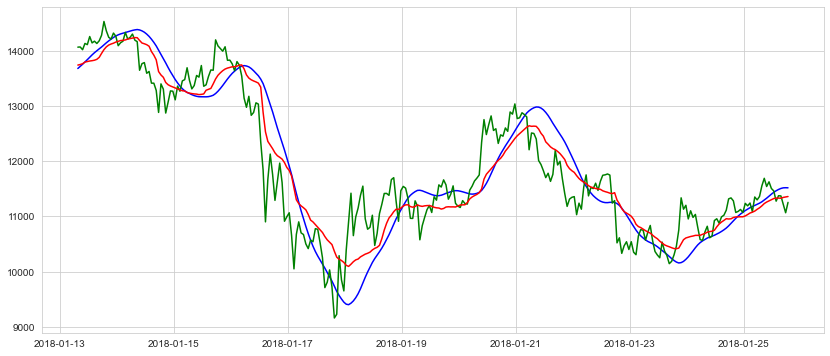

In [219]:
plt.figure(figsize = (14, 6))
plt.plot(data["hma"][200:500], color = "blue")
plt.plot(data["Close"][200:500], color = "green")
plt.plot(data["vwap"][200:500], color = "red")